In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
# Hyperparams
batch_size = 128
learning_rate = 0.001
num_classes = 10
epochs_teacher = 2
epochs_student = 2
epochs_fine_tuning = 2
momentum = 0.9
alpha = 0.9
temperature = 3.0
log_interval = 200
learning_rate_fine_tuning = learning_rate / 10
width = 0.35

In [3]:
# Data Loaders for CIFAR10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 43185896.28it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# ResNet50 Teacher Model
teacher = torchvision.models.resnet50(weights=None, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
teacher_optimizer = optim.SGD(teacher.parameters(), lr=learning_rate, momentum=momentum)

In [6]:
# Training loop for the Teacher
for epoch in range(epochs_teacher):
    teacher.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        teacher_optimizer.zero_grad()
        outputs = teacher(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        teacher_optimizer.step()

        running_loss += loss.item()
        if i % log_interval == log_interval-1:
            print(f"[Teacher Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / log_interval:.3f}")
            running_loss = 0.0

print("Finished Training Teacher")

[Teacher Epoch 1, Batch 200] Loss: 2.256
[Teacher Epoch 2, Batch 200] Loss: 1.834
Finished Training Teacher


In [7]:
# Student Model: Simple CNN
class StudentCNN(nn.Module):
    def __init__(self):
        super(StudentCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

student = StudentCNN().to(device)
student_optimizer = optim.SGD(student.parameters(), lr=learning_rate, momentum=momentum)

In [8]:
# # Knowledge Distillation Loss
# def distillation_loss(student_outputs, teacher_outputs, labels, alpha=alpha, temperature=temperature):
#     hard_loss = nn.CrossEntropyLoss()(student_outputs, labels) * (1. - alpha)
#     soft_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(student_outputs / temperature, dim=1),
#                              F.softmax(teacher_outputs / temperature, dim=1)) * (alpha * temperature * temperature)
#     return hard_loss + soft_loss

In [9]:
# Extract Bias Vector
def extract_bias_vector(model, dataloader, layer_name):
    model.eval()
    activations = []
    def hook(module, input, output):
        activations.append(output)
    hook_ref = getattr(model, layer_name).register_forward_hook(hook)
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.cuda()
            model(inputs)
    hook_ref.remove()
    bias_vector = torch.cat(activations).mean(dim=0)
    return bias_vector

In [10]:
# Distillation Loss with Bias
lambda_bias=0.1

def distillation_loss_with_bias(outputs, labels, teacher_outputs, teacher_bias, student_bias, alpha=alpha, temperature=temperature, lambda_bias=lambda_bias):
    KD_loss = nn.KLDivLoss()(F.log_softmax(outputs / temperature, dim=1),
                             F.softmax(teacher_outputs / temperature, dim=1)) * (alpha * temperature * temperature)
    CE_loss = F.cross_entropy(outputs, labels) * (1. - alpha)
    bias_diff = (teacher_bias - student_bias).pow(2).mean()
    bias_loss = lambda_bias * bias_diff
    return KD_loss + CE_loss + bias_loss

In [11]:
# lambda_fairness = 1.0 #fairness regularization

# # Define the fairness loss
# def fairness_loss(outputs, labels, group_ids):
#     group0_mask = (group_ids == 0)
#     group1_mask = (group_ids == 1)

#     group0_loss = nn.CrossEntropyLoss(reduction='mean')(outputs[group0_mask], labels[group0_mask])
#     group1_loss = nn.CrossEntropyLoss(reduction='mean')(outputs[group1_mask], labels[group1_mask])

#     return torch.abs(group0_loss - group1_loss)

# # Modify the distillation loss to include the fairness loss
# def distillation_loss_with_fairness(student_outputs, teacher_outputs, labels, group_ids, alpha=alpha, temperature=temperature):
#     hard_loss = nn.CrossEntropyLoss()(student_outputs, labels) * (1. - alpha)
#     soft_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(student_outputs / temperature, dim=1),
#                              F.softmax(teacher_outputs / temperature, dim=1)) * (alpha * temperature * temperature)
#     fair_loss = fairness_loss(student_outputs, labels, group_ids)

#     return hard_loss + soft_loss + lambda_fairness * fair_loss

In [12]:
# Train the Student using Knowledge Distillation
teacher.eval()
teacher_bias_vector = extract_bias_vector(teacher, trainloader, 'fc')

In [13]:
# Train the Student using Knowledge Distillation
teacher.eval()
for epoch in range(epochs_student):
    student_bias_vector = extract_bias_vector(student, trainloader, 'fc2')
    student.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        student_optimizer.zero_grad()
        student_outputs = student(inputs)
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
        # loss = distillation_loss(student_outputs, teacher_outputs, labels)
        loss = distillation_loss_with_bias(student_outputs, labels, teacher_outputs, teacher_bias_vector, student_bias_vector)
        loss.backward()
        student_optimizer.step()

        running_loss += loss.item()
        if i % log_interval == log_interval-1:
            print(f"[Student (Distillation) Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / log_interval:.3f}")
            running_loss = 0.0

print("Finished Knowledge Distillation")

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


[Student (Distillation) Epoch 1, Batch 200] Loss: 0.360
[Student (Distillation) Epoch 2, Batch 200] Loss: 0.356
Finished Knowledge Distillation


In [14]:
# Fine-tune the Student
student_optimizer_fine_tuning = optim.SGD(student.parameters(), lr=learning_rate_fine_tuning, momentum=momentum)
for epoch in range(epochs_fine_tuning):
    student.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        student_optimizer_fine_tuning.zero_grad()
        outputs = student(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        student_optimizer_fine_tuning.step()

        running_loss += loss.item()
        if i % log_interval == log_interval-1:
            print(f"[Student (Fine-tuning) Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / log_interval:.3f}")
            running_loss = 0.0

print("Finished Fine-Tuning Student")

[Student (Fine-tuning) Epoch 1, Batch 200] Loss: 2.281
[Student (Fine-tuning) Epoch 2, Batch 200] Loss: 2.269
Finished Fine-Tuning Student


In [15]:
# Evaluate function
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    return accuracy, all_preds, all_labels

In [16]:
# Evaluate both Teacher and Student models
teacher_acc, teacher_preds, teacher_labels = evaluate(teacher, testloader)
student_acc, student_preds, student_labels = evaluate(student, testloader)

In [17]:
# Performance metrics
teacher_precision = precision_score(teacher_labels, teacher_preds, average='weighted')
student_precision = precision_score(student_labels, student_preds, average='weighted')

teacher_recall = recall_score(teacher_labels, teacher_preds, average='weighted')
student_recall = recall_score(student_labels, student_preds, average='weighted')

teacher_f1 = f1_score(teacher_labels, teacher_preds, average='weighted')
student_f1 = f1_score(student_labels, student_preds, average='weighted')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
# Model Size
teacher_size = sum(p.numel() for p in teacher.parameters())
student_size = sum(p.numel() for p in student.parameters())

In [19]:
# Inference Time
def infer_time(model, dataloader):
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
    end_time = time.time()
    return (end_time - start_time) / len(dataloader.dataset)

teacher_infer_time = infer_time(teacher, testloader)
student_infer_time = infer_time(student, testloader)

In [20]:
def evaluate_fairness(model, dataloader):
    model.eval()
    probs_0 = []
    probs_2 = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = F.softmax(model(inputs), dim=1)
            probs_0.extend(outputs[:, 0].cpu().numpy())
            probs_2.extend(outputs[:, 2].cpu().numpy())
    return np.mean(probs_0), np.mean(probs_2)


In [21]:
def evaluate_fairness_all_classes(model, dataloader, num_classes=num_classes):
    model.eval()
    total_probs = np.zeros(num_classes)
    total_samples = 0

    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = F.softmax(model(inputs), dim=1)
            total_probs += outputs.sum(dim=0).cpu().numpy()
            total_samples += outputs.size(0)

    return total_probs / total_samples

In [22]:
# teacher_probs_0, teacher_probs_2 = evaluate_fairness(teacher, trainloader)
# student_probs_0, student_probs_2 = evaluate_fairness(student, trainloader)

teacher_probs = evaluate_fairness_all_classes(teacher, trainloader)
student_probs = evaluate_fairness_all_classes(student, trainloader)

# teacher_discrepancy = abs(teacher_probs_0 - teacher_probs_2)
# student_discrepancy = abs(student_probs_0 - student_probs_2)

teacher_discrepancy = np.std(teacher_probs)
student_discrepancy = np.std(student_probs)

# Metrics and values for visualization

performance_metrics = ['Accuracy']
performance_teacher_values = [teacher_acc]
performance_student_values = [student_acc]

time_metrics = ['Inference Time']
time_teacher_values = [teacher_infer_time]
time_student_values = [student_infer_time]

size_metrics = ['Model Size']
size_teacher_values = [sum(p.numel() for p in teacher.parameters())]
size_student_values = [sum(p.numel() for p in student.parameters())]

fairness_metrics = ['Fairness Discrepancy']
fairness_teacher_values = [teacher_discrepancy]
fairness_student_values = [student_discrepancy]

x_perf = np.arange(len(performance_metrics))
x_time = np.arange(len(time_metrics))
x_size = np.arange(len(size_metrics))
x_fairness = np.arange(len(fairness_metrics))

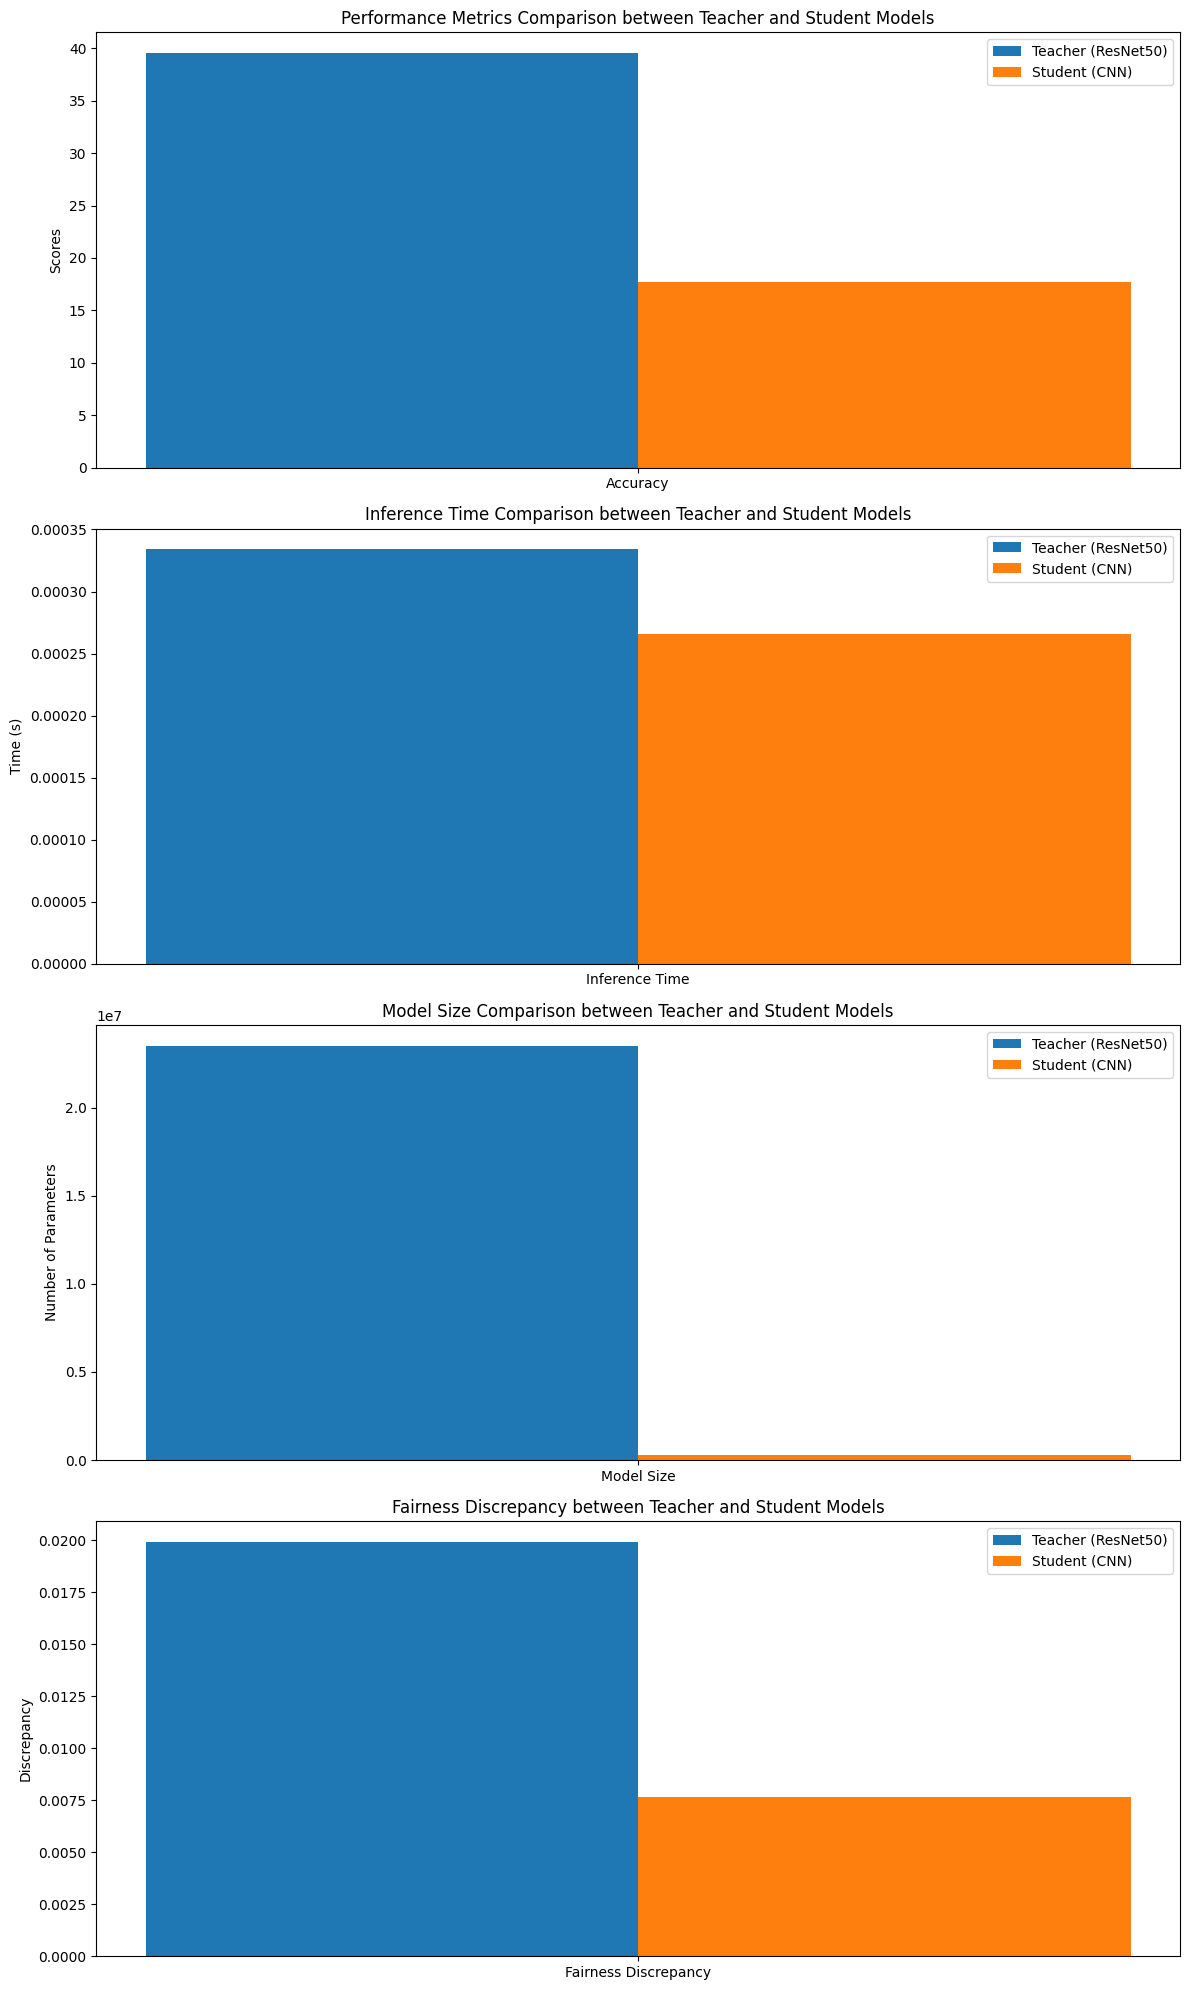

In [23]:
fig, axs = plt.subplots(4, 1, figsize=(12, 20))  # Adjusted for 4 subplots

# Performance Metrics
axs[0].bar(x_perf - width/2, performance_teacher_values, width, label='Teacher (ResNet50)')
axs[0].bar(x_perf + width/2, performance_student_values, width, label='Student (CNN)')
axs[0].set_ylabel('Scores')
axs[0].set_title('Performance Metrics Comparison between Teacher and Student Models')
axs[0].set_xticks(x_perf)
axs[0].set_xticklabels(performance_metrics)
axs[0].legend()

# Inference Time
axs[1].bar(x_time - width/4, time_teacher_values, width/2, label='Teacher (ResNet50)')
axs[1].bar(x_time + width/4, time_student_values, width/2, label='Student (CNN)')
axs[1].set_ylabel('Time (s)')
axs[1].set_title('Inference Time Comparison between Teacher and Student Models')
axs[1].set_xticks(x_time)
axs[1].set_xticklabels(time_metrics)
axs[1].legend()

# Model Size
axs[2].bar(x_size - width/4, size_teacher_values, width/2, label='Teacher (ResNet50)')
axs[2].bar(x_size + width/4, size_student_values, width/2, label='Student (CNN)')
axs[2].set_ylabel('Number of Parameters')
axs[2].set_title('Model Size Comparison between Teacher and Student Models')
axs[2].set_xticks(x_size)
axs[2].set_xticklabels(size_metrics)
axs[2].legend()

# Fairness/Bias
axs[3].bar(x_fairness - width/4, fairness_teacher_values, width/2, label='Teacher (ResNet50)')
axs[3].bar(x_fairness + width/4, fairness_student_values, width/2, label='Student (CNN)')
axs[3].set_ylabel('Discrepancy')
axs[3].set_title('Fairness Discrepancy between Teacher and Student Models')
axs[3].set_xticks(x_fairness)
axs[3].set_xticklabels(fairness_metrics)
axs[3].legend()

fig.tight_layout()
plt.show()

In [24]:
# Using the new method to evaluate overall fairness
teacher_probs = evaluate_fairness_all_classes(teacher, trainloader)
student_probs = evaluate_fairness_all_classes(student, trainloader)

teacher_discrepancy = np.std(teacher_probs)
student_discrepancy = np.std(student_probs)

print(f"\nOverall fairness discrepancy for teacher: {teacher_discrepancy:.4f}")
print(f"Overall fairness discrepancy for student: {student_discrepancy:.4f}")

# Compare
if teacher_discrepancy < student_discrepancy:
    print("Overall, the Teacher is more fair than student.")
elif teacher_discrepancy > student_discrepancy:
    print("Overall, the Student is more fair than teacher.")
else:
    print("Overall, both the teacher and the student have the same level of fairness.")


Overall fairness discrepancy for teacher: 0.0199
Overall fairness discrepancy for student: 0.0076
Overall, Student is more fair than teacher.
